In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
import predict
import base
import shop_classify as sc

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
def plot_validation_curve(estimator, X, y, title, param_name=None, param_range=None,
                        cv=5, scoring='accuracy', n_jobs=1):
    
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [5]:
#读取训练集
X_train_df = pd.read_csv("./data/dataset/dataset/shop_classify/check/train/X_train.txt", sep='\t', index_col=0, encoding='UTF-8')
y_train_df = pd.read_csv("./data/dataset/dataset/shop_classify/check/train/y_train.txt", sep='\t', header = None, index_col=0, encoding='UTF-8')

In [6]:
X_train_df = X_train_df.astype(np.int)

In [15]:
names = ['3_1', '3_2', '3_3', 'arima']
train_evaluations = []

for i in range(len(names)):
    train_evaluations.append(pd.read_csv("./data/dataset/dataset/shop_classify/check/train/" + names[i] + "_evaluation.txt", sep='\t', encoding='UTF-8', index_col=0))

In [8]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_train_df.values, y_train_df[1].values, test_size=0.5, random_state=0)   

In [13]:
# Set the parameters by cross-validation

#random_state=0, min_samples_split=30, max_depth=3, learning_rate=0.05, min_samples_leaf=5, n_estimators=50
tuned_parameters = {'learning_rate': [0.05, 0.07], 'n_estimators': [50, 70],
                     'min_samples_split': [10, 15, 20], 'min_samples_leaf': [5, 10], 'max_depth': [3]}


gbdt = GradientBoostingClassifier(random_state=0)

clf = GridSearchCV(gbdt, tuned_parameters, cv=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'min_samples_leaf': 5, 'n_estimators': 70, 'min_samples_split': 20, 'learning_rate': 0.05, 'max_depth': 3}

Grid scores on development set:

0.873 (+/-0.017) for {'min_samples_leaf': 5, 'n_estimators': 50, 'min_samples_split': 10, 'learning_rate': 0.05, 'max_depth': 3}
0.873 (+/-0.017) for {'min_samples_leaf': 5, 'n_estimators': 70, 'min_samples_split': 10, 'learning_rate': 0.05, 'max_depth': 3}
0.878 (+/-0.009) for {'min_samples_leaf': 5, 'n_estimators': 50, 'min_samples_split': 15, 'learning_rate': 0.05, 'max_depth': 3}
0.879 (+/-0.012) for {'min_samples_leaf': 5, 'n_estimators': 70, 'min_samples_split': 15, 'learning_rate': 0.05, 'max_depth': 3}
0.879 (+/-0.009) for {'min_samples_leaf': 5, 'n_estimators': 50, 'min_samples_split': 20, 'learning_rate': 0.05, 'max_depth': 3}
0.880 (+/-0.010) for {'min_samples_leaf': 5, 'n_estimators': 70, 'min_samples_split': 20, 'learning_rate': 0.05, 'max_depth': 3}
0.880 (+/-0.011) for {'min_samples_le

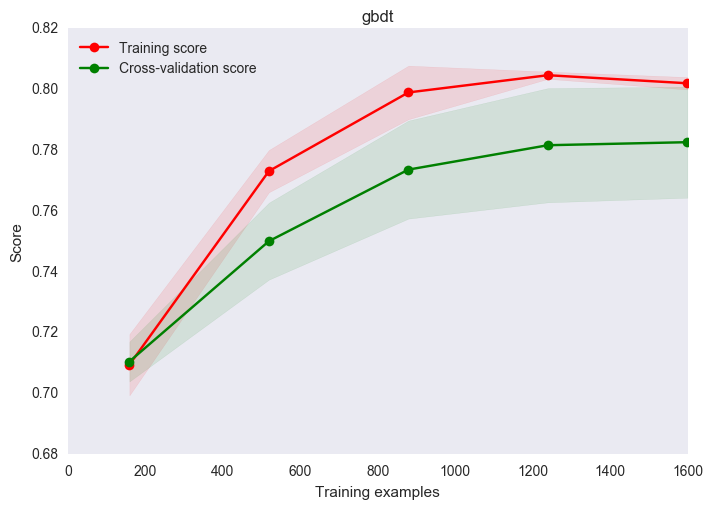

In [46]:

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=40, max_depth=5, min_samples_split=30, min_samples_leaf=20, max_leaf_nodes=10, random_state=0)
plot_learning_curve(rfc, 'gbdt', X_validation_df.values, y_true_validation_df[1].values, cv=5)
plt.show()

In [30]:
rfc.fit(X_train_df.values, y_train_df[1].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=10,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [31]:
rfc.score(X_validation_df.values, y_true_validation_df[1].values)

0.28649999999999998

In [36]:
y_predict = clf.predict(fix_X_train_df.values)

In [37]:
len(y_predict)

2000

In [38]:
#计算验证集的loss

In [40]:
combine_evaluation = {}
for i, t in enumerate(y_predict):
    print(t)
    combine_evaluation[i + 1] = validation_evaluations[t + 4].loc[i + 1]
    
combine_evaluation_df = pd.DataFrame(combine_evaluation);
combine_evaluation_df = combine_evaluation_df.T

6
2
3
6
1
6
2
6
6
6
3
3
6
6
3
6
2
6
6
6
3
6
6
3
2
3
3
2
6
6
6
6
6
6
6
6
2
6
1
6
6
6
6
6
6
6
6
6
1
3
1
2
6
3
6
2
6
6
6
2
3
5
6
6
6
3
6
6
6
4
6
6
6
3
6
6
3
6
3
6
6
3
6
4
6
6
6
6
6
6
6
6
6
6
6
2
6
3
1
6
6
6
6
2
6
3
3
3
6
6
6
6
6
6
6
1
2
3
6
6
6
6
6
6
6
1
3
6
6
6
3
3
6
1
2
3
3
6
6
6
6
6
6
6
2
6
2
6
6
6
3
6
3
1
6
6
2
6
2
6
6
3
3
6
6
6
1
2
3
6
6
6
6
1
3
3
6
3
3
4
2
6
6
6
3
6
6
3
6
6
2
2
6
6
6
6
3
6
3
6
6
1
6
6
6
6
6
6
2
3
2
6
1
6
4
3
6
6
6
3
2
6
6
6
2
6
3
3
6
6
3
6
6
6
6
3
6
3
2
6
6
6
6
1
1
6
6
6
6
6
6
6
6
1
6
6
3
3
3
2
2
6
6
6
6
2
6
3
6
6
6
1
6
3
6
3
6
6
6
3
6
6
6
6
6
1
6
3
3
3
3
6
6
6
6
6
6
6
6
3
6
6
2
6
6
6
6
6
3
6
3
6
6
3
5
1
6
6
1
6
6
3
6
3
6
6
6
2
3
6
6
6
6
6
3
6
2
1
6
6
6
6
3
2
6
6
6
6
3
6
3
6
3
6
6
6
6
2
6
6
6
6
3
6
2
3
6
1
6
6
6
3
3
6
6
2
6
6
6
6
3
3
1
6
3
6
3
6
6
6
6
6
6
1
6
3
3
3
6
6
1
6
6
6
6
1
6
6
6
6
2
6
6
6
6
3
1
5
6
6
3
2
6
6
6
6
6
6
6
6
6
3
3
6
6
6
2
3
6
2
2
2
6
6
3
3
6
6
6
6
6
6
6
6
6
2
3
6
6
6
6
6
2
6
6
3
2
2
6
3
6
6
6
3
3
6
2
6
3
6
6
2
3
6
3
6
3
6
3
6
2
6
1
6
3
3
6
6
2
4


In [41]:
combine_evaluation_df.mean()

evaluation    0.142096
dtype: float64

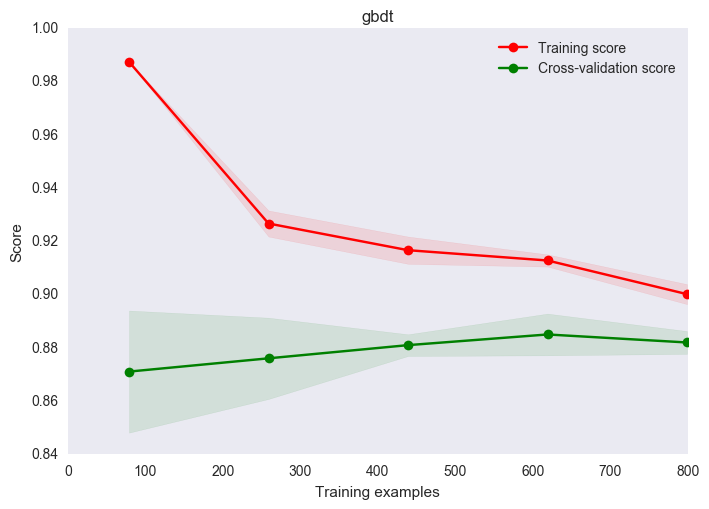

In [9]:
#{'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.07, 'n_estimators': 70}
#n_estimators': 250, 'min_samples_split': 30, 'learning_rate': 0.05, 'min_samples_leaf': 20, 'max_depth': 8
#25, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.07, 'n_estimators': 70
#{'min_samples_split': 20, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 70, 'learning_rate': 0.05}
#(random_state=0, min_samples_split=20, max_depth=3, learning_rate=0.05, min_samples_leaf=7, n_estimators=60)
learning_gbdt = GradientBoostingClassifier(random_state=0, min_samples_split=20, max_depth=3, learning_rate=0.05, min_samples_leaf=5, n_estimators=40)
#plot_learning_curve(learning_gbdt, 'gbdt', X_validation_df.values, y_true_validation_df[1].values, cv=5)
plot_learning_curve(learning_gbdt, 'gbdt', X_train, y_train, cv=5)
plt.show()

In [10]:
learning_gbdt.fit(X_train, y_train)
#learning_gbdt.fit(X_validation_df.values, y_true_validation_df[1].values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=20, min_weight_fraction_leaf=0.0,
              n_estimators=40, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [12]:
#learning_gbdt.score(X_train_df.values, y_train_df[1].values)
learning_gbdt.score(X_test, y_test)

0.879

In [13]:
y_predict = learning_gbdt.predict(X_test)
#y_predict = learning_gbdt.predict(X_train_df.values)

In [14]:
combine_evaluation = {}
for i, t in enumerate(y_predict):
    if t == 0:
        combine_evaluation[i + 1] = train_evaluations[3].loc[i + 1]
    else:
        combine_evaluation[i + 1] = train_evaluations[5].loc[i + 1]
    #combine_evaluation[i + 1] = train_evaluations[t + 4].loc[i + 1]
    #combine_evaluation[i + 1] = validation_evaluations[t + 4].loc[i + 1]
combine_evaluation_df = pd.DataFrame(combine_evaluation);
combine_evaluation_df = combine_evaluation_df.T

IndexError: list index out of range

In [16]:
combine_evaluation_df.mean()

evaluation    0.171757
dtype: float64

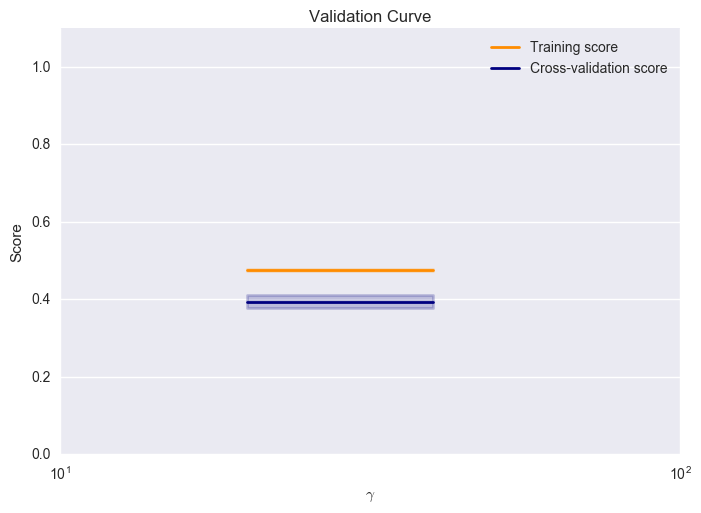

In [22]:
plot_validation_curve(learning_gbdt, fix_X_train_df.values, y_train_df[1].values, 'gbdt', param_name='min_samples_split', param_range=[20,30,40],
                        cv=5, scoring='accuracy', n_jobs=1)

In [39]:
predict_names = ["2_2_1", '2_2_2', '3_3_1', '3_3_2', '3_3_3', 'arima']
predict_predictions = []

for name in predict_names:
    predict_predictions.append(pd.read_csv("./data/dataset/dataset/shop_classify/check/predict/" + name + "_prediction.txt", sep='\t', encoding='UTF-8', index_col=0))

In [40]:
X_predict_df = pd.read_csv("./data/dataset/dataset/shop_classify/check/predict/X_predict.txt", sep='\t', index_col=0, encoding='UTF-8')

In [41]:
X_predict_df = X_predict_df.astype(np.int)

In [42]:
y_predict = learning_gbdt.predict(X_predict_df.values)

In [43]:
combine_prediction = {}
for i, t in enumerate(y_predict):
    print(t)
    if t == 0:
        combine_prediction[i + 1] = predict_predictions[4].loc[i + 1]
    else:
        combine_prediction[i + 1] = predict_predictions[5].loc[i + 1]
combine_prediction_df = pd.DataFrame(combine_prediction);
combine_prediction_df = combine_prediction_df.T

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [44]:
combine_prediction_df = predict.FixFinalPredict(combine_prediction_df)

In [45]:
combine_prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,251,196,220,243,239,262,201,251,196,220,243,239,262,201
2,79,87,92,72,135,133,80,79,87,92,72,135,133,80
3,69,65,70,92,116,108,63,69,65,70,92,116,108,63
4,88,109,61,103,197,205,95,88,109,61,103,197,205,95
5,242,143,230,199,183,247,322,242,143,230,199,183,247,322
6,94,98,99,120,103,110,91,94,98,99,120,103,110,91
7,121,100,117,133,166,190,113,121,100,117,133,166,190,113
8,66,62,70,48,80,87,56,66,62,70,48,80,87,56
9,205,204,221,203,254,291,237,205,204,221,203,254,291,237
10,91,121,83,85,89,103,92,91,121,83,85,89,103,92


In [46]:
combine_prediction_df.to_csv("./data/dataset/dataset/shop_classify/check/predict/combine_prediction.csv", header = None, index=True, encoding='UTF-8')